In [1]:
import yaml
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import numpy as np


def load_config(config_path: str) -> dict:

    # Open the YAML file, load its content, and return dictionary
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config


config = load_config("config/competition.yaml")

DataLoading and model definition

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class simpleCNN(nn.Module):
    def __init__(
        self, input_channels=3, hidden_size=256, max_gates=5, num_features=512
    ):
        super().__init__()
        self.max_gates = max_gates

        # Convolutional layers with reduced max pooling
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.InstanceNorm2d(32, affine=True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.InstanceNorm2d(64, affine=True)
        # First max pooling layer after two convolutions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.InstanceNorm2d(128, affine=True)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.InstanceNorm2d(256, affine=True)
        # Second max pooling layer after two more convolutions
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.InstanceNorm2d(512, affine=True)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(
            512 * 60 * 80, 512
        )  # Adjust input size based on your input dimensions
        self.fc2 = nn.Linear(512, 512)

        self.fc_coords = nn.Linear(512, max_gates * 8)
        self.fc_visibility = nn.Linear(512, max_gates * 4)
        self.fc_conf = nn.Linear(512, max_gates)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature Extraction with Convolutional Layers
        x = F.relu(self.bn1(self.conv1(x)))  # -> [batch, 32, H, W]
        x = F.relu(self.bn2(self.conv2(x)))

        x = self.pool1(x)  # First max pooling -> [batch, 64, H/2, W/2]

        x = F.relu(self.bn3(self.conv3(x)))  # -> [batch, 128, H/2, W/2]
        x = F.relu(self.bn4(self.conv4(x)))  # -> [batch, 256, H/2, W/2]
        x = self.pool2(x)  # Second max pooling -> [batch, 256, H/4, W/4]

        x = F.relu(self.bn5(self.conv5(x)))  # -> [batch, 512, H/4, W/4]
        x = self.pool3(x)

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)  # Flatten -> [batch, 512 * H/32 * W/32]

        # Fully connected layers
        x = F.relu(self.fc1(x))  # -> [batch, 1024]
        x = F.relu(self.fc2(x))  # -> [1024, 1024]

        # Predict gate coordinates
        gate_coords = torch.sigmoid(self.fc_coords(x))  # Output: [batch, max_gates * 8]
        gate_coords = gate_coords.view(
            -1, self.max_gates, 8
        )  # Reshape to [batch, max_gates, 8]

        # Predict gate visibility
        gate_visibility = (
            torch.sigmoid(self.fc_visibility(x)) * 2
        )  # Output: [batch, max_gates * 4]
        gate_visibility = gate_visibility.view(
            -1, self.max_gates, 4
        )  # Reshape to [batch, max_gates, 4]

        # Predict gate confidence
        gate_conf = torch.sigmoid(self.fc_conf(x))  # Output: [batch, max_gates]

        # Combine coordinates and visibility into a single tensor with xyvisibility times 4
        batch_size = gate_coords.size(0)
        interwoven_output = torch.zeros(
            batch_size, self.max_gates, 12, device=gate_coords.device
        )

        # Interweave the values
        interwoven_output[:, :, 0::3] = gate_coords[:, :, 0::2]  # x1, x2, x3, x4
        interwoven_output[:, :, 1::3] = gate_coords[:, :, 1::2]  # y1, y2, y3, y4
        interwoven_output[:, :, 2::3] = gate_visibility  # v1, v2, v3, v4

        return interwoven_output, gate_conf


# class STML(nn.Module):
#     def __init__(
#         self, input_channels=3, hidden_size=256, max_gates=5, num_features=512
#     ):
#         super(STML, self).__init__()

#         self.max_gates = max_gates
#         self.hidden_size = hidden_size
#         self.num_features = num_features

#         # Convolutional Backbone
#         self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.conv5 = nn.Conv2d(256, num_features, kernel_size=3, stride=1, padding=1)

#         # Batch Normalization
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.bn5 = nn.BatchNorm2d(num_features)

#         # LSTM for Sequential Gate Prediction with 1 layer
#         self.lstm = nn.LSTM(
#             input_size=num_features,
#             hidden_size=hidden_size,
#             num_layers=1,  # Reduced to 1 layer
#             batch_first=True,
#         )

#         # Final Fully Connected Layers to Predict Coordinates, Visibility, and Confidence
#         self.fc_x = nn.Linear(hidden_size, 4)  # Predict x for each corner
#         self.fc_y = nn.Linear(hidden_size, 4)  # Predict y for each corner
#         self.fc_visibility = nn.Linear(
#             hidden_size, 4
#         )  # Predict visibility for each corner
#         self.fc_conf = nn.Linear(
#             hidden_size, 1
#         )  # Predict confidence score for gate presence

#     def forward(self, x):
#         # Convolutional Feature Extraction
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)

#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)

#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)

#         x = F.relu(self.bn4(self.conv4(x)))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)

#         x = F.relu(self.bn5(self.conv5(x)))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)

#         # Flatten to (batch_size, num_features)
#         batch_size = x.size(0)
#         x = x.view(batch_size, self.num_features, -1)
#         x = torch.mean(x, dim=-1)  # Global average pooling to reduce spatial dimensions

#         # Expand the input for LSTM to predict a sequence of gate coordinates
#         # Repeat input for max_gates times to predict that many gate sequences
#         x = x.unsqueeze(1).repeat(
#             1, self.max_gates, 1
#         )  # Shape: (batch_size, max_gates, num_features)

#         # LSTM for Sequential Processing
#         h0 = torch.zeros(1, batch_size, self.hidden_size).to(
#             x.device
#         )  # Initialize hidden state (1 layer)
#         c0 = torch.zeros(1, batch_size, self.hidden_size).to(
#             x.device
#         )  # Initialize cell state (1 layer)

#         lstm_out, _ = self.lstm(
#             x, (h0, c0)
#         )  # Shape: (batch_size, max_gates, hidden_size)

#         # Predict gate coordinates (x, y) and visibility for each gate in the sequence
#         x_coords = torch.sigmoid(
#             self.fc_x(lstm_out)
#         )  # Shape: (batch_size, max_gates, 4), scaled to [0, 1]
#         y_coords = torch.sigmoid(
#             self.fc_y(lstm_out)
#         )  # Shape: (batch_size, max_gates, 4), scaled to [0, 1]

#         gate_visibility_Raw = torch.sigmoid(self.fc_visibility(lstm_out)) * 2
#         gate_visibility = torch.where(
#             gate_visibility_Raw >= 0.5,
#             torch.tensor(2.0, device=x.device),
#             torch.tensor(0.0, device=x.device),
#         )  # Shape: (batch_size, max_gates, 4), scaled to [0, 2]

#         gate_conf = torch.sigmoid(self.fc_conf(lstm_out)).squeeze(
#             -1
#         )  # Shape: (batch_size, max_gates)

#         # Reshape x, y, and visibility to (batch_size, max_gates, 12) with (x, y, visibility) format
#         x_y_vis_output = torch.stack(
#             [x_coords, y_coords, gate_visibility], dim=-1
#         ).view(batch_size, self.max_gates, -1)

#         return x_y_vis_output, gate_conf

In [3]:
import torch

model = simpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force cpu as dvice
# device = torch.device("cpu")
model = model.to(device)
print(f"Device: {device}")

Device: cuda


Defining data loaders and datasets

In [4]:
from torch.utils.data import DataLoader, random_split, Dataset
from dataloading_RNN import DroneDataset

data_path = "/workspaces/AE4353-Y24/competition/data/Autonomous"
dataset = DroneDataset(data_path)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create training set loader
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config["num_workers_train_loader"],
)

# Create validation set loader
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batchsize_val"],
    shuffle=False,
    num_workers=config["num_workers_val_loader"],
)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

In [5]:
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F


# def visualize_feature_maps(image, model, device):
#     """
#     Visualize feature maps for each convolutional layer in the model.

#     Args:
#         image (torch.Tensor): Input image tensor of shape (1, 3, H, W).
#         model (torch.nn.Module): CNN model.
#         device (torch.device): Device on which model and input are located.
#     """
#     # Move the image to the same device as the model
#     image = image.to(device)

#     # Assuming your model has conv1, conv2, conv3, conv4, conv5 defined as in the code snippet.
#     feature_maps = []

#     # First Convolution and Max Pooling
#     x = F.relu(model.bn1(model.conv1(image)))
#     feature_maps.append(x)  # Save feature map
#     x = F.max_pool2d(x, kernel_size=2, stride=2)

#     # Second Convolution and Max Pooling
#     x = F.relu(model.bn2(model.conv2(x)))
#     feature_maps.append(x)
#     x = F.max_pool2d(x, kernel_size=2, stride=2)

#     # Third Convolution and Max Pooling
#     x = F.relu(model.bn3(model.conv3(x)))
#     feature_maps.append(x)
#     x = F.max_pool2d(x, kernel_size=2, stride=2)

#     # Fourth Convolution and Max Pooling
#     x = F.relu(model.bn4(model.conv4(x)))
#     feature_maps.append(x)
#     x = F.max_pool2d(x, kernel_size=2, stride=2)

#     # Fifth Convolution and Max Pooling
#     x = F.relu(model.bn5(model.conv5(x)))
#     feature_maps.append(x)
#     x = F.max_pool2d(x, kernel_size=2, stride=2)

#     # Plot feature maps for each convolutional layer
#     for i, fmap in enumerate(feature_maps):
#         fmap = fmap.squeeze(0).detach().cpu().numpy()  # Convert to numpy array
#         fig, axes = plt.subplots(
#             4, 8, figsize=(15, 8)
#         )  # Adjust subplots based on number of channels
#         fig.suptitle(f"Feature Maps after Convolution Layer {i + 1}")

#         for j, ax in enumerate(axes.flat):
#             if j < fmap.shape[0]:  # Check if channel exists
#                 ax.imshow(fmap[j], cmap="gray")
#                 ax.axis("off")
#             else:
#                 fig.delaxes(ax)  # Remove empty subplots

#         plt.show()

In [6]:
# # load single image
# image, target = dataset[0]
# visualize_feature_maps(image, model, device=device)

Loss function

In [7]:
import torch
import torch.nn.functional as F
from torchsort import soft_rank


# def simple_custom_loss(gt_coords, pred_coords, gt_conf, pred_conf, p_max):
#     """
#     Custom loss function that applies penalties to the x, y, visibility, and confidence values.

#     Args:
#         gt_coords: Ground truth coordinates tensor of shape (batch_size, max_gates, 12).
#         pred_coords: Predicted coordinates tensor of shape (batch_size, max_gates, 12).
#         gt_conf: Ground truth confidence tensor of shape (batch_size, max_gates).
#         pred_conf: Predicted confidence tensor of shape (batch_size, max_gates).
#         p_max: Maximum penalty for visibility discrepancy.

#     Returns:
#         loss: Computed loss value.
#     """
#     # Initialize total loss
#     total_loss = 0.0
#     batch_size = gt_coords.size(0)

#     for batch in range(batch_size):
#         # Extract batch values
#         gt_batch = gt_coords[batch]  # Shape: (max_gates, 12)
#         pred_batch = pred_coords[batch]  # Shape: (max_gates, 12)
#         gt_conf_batch = gt_conf[batch]  # Shape: (max_gates,)
#         pred_conf_batch = pred_conf[batch]  # Shape: (max_gates,)

#         pred_xy = pred_batch[:, [0, 1, 3, 4, 6, 7, 9, 10]]
#         gt_xy = gt_batch[:, [0, 1, 3, 4, 6, 7, 9, 10]]

#         # Penalty for x, y values
#         xy_loss = torch.sum((pred_xy - gt_xy) ** 2)

#         pred_visibility = pred_batch[:, [2, 5, 8, 11]]
#         gt_visibility = gt_batch[:, [2, 5, 8, 11]]

#         # print(gt_visibility)
#         # Penalty for visibility (consider visibility values between 0 and 2)

#         visibility_loss = torch.sum((pred_visibility - gt_visibility) ** 2) / 40

#         # Penalty for confidence values using binary cross-entropy loss
#         conf_loss = torch.sum((gt_conf_batch - pred_conf_batch) ** 2)

#         # # print all losses
#         # print(
#         #     f"xy_loss: {xy_loss.item()}, visibility_loss: {visibility_loss.item()}, conf_loss: {conf_loss.item()}"
#         # )

#         # Total loss is the sum of individual losses
#         total_loss += xy_loss * 8 + visibility_loss + conf_loss
#         # print fractions of losses for each batch

#     return total_loss / batch_size

import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment


def simple_custom_loss(gt_coords, pred_coords, gt_conf, pred_conf, p_max, beta=10.0):
    """
    Custom loss function with soft assignment and penalties for unmatched gates.
    Args:
        gt_coords: Ground truth coordinates of shape (batch_size, max_gates, 12).
        pred_coords: Predicted coordinates of shape (batch_size, max_gates, 12).
        gt_conf: Ground truth confidence values of shape (batch_size, max_gates).
        pred_conf: Predicted confidence values of shape (batch_size, max_gates).
        p_max: Maximum penalty for unmatched gates.
        beta: Sharpness parameter for soft assignment (higher values lead to sharper assignments).
    """
    total_loss = 0.0
    batch_size = gt_coords.size(0)

    for batch in range(batch_size):
        gt_batch = gt_coords[batch]  # Shape: (max_gates, 12)
        pred_batch = pred_coords[batch]  # Shape: (max_gates, 12)
        gt_conf_batch = gt_conf[batch]  # Shape: (max_gates,)
        pred_conf_batch = pred_conf[batch]  # Shape: (max_gates,)

        # Calculate distances for (x, y) pairs
        gt_xy = gt_batch[:, [0, 1, 3, 4, 6, 7, 9, 10]].view(
            -1, 4, 2
        )  # Shape: (max_gates, 4, 2)
        pred_xy = pred_batch[:, [0, 1, 3, 4, 6, 7, 9, 10]].view(
            -1, 4, 2
        )  # Shape: (max_gates, 4, 2)

        distances = torch.cdist(pred_xy, gt_xy, p=2).mean(
            dim=-1
        )  # Shape: (max_gates, max_gates)

        # Calculate soft assignment matrix using softmax
        assignment_matrix = F.softmax(
            -beta * distances, dim=1
        )  # Shape: (max_gates, max_gates)

        # Matched gate loss
        matched_loss = (
            assignment_matrix * distances
        ).sum()  # Weighted sum of distances

        # Confidence loss sum of squared error
        confidence_loss = torch.sum((pred_conf_batch - gt_conf_batch) ** 2)
        # confidence_loss = F.mse_loss(pred_conf_batch, gt_conf_batch)

        # Visibility loss (soft assignment weighted)
        gt_visibility = gt_batch[:, [2, 5, 8, 11]] / 2  # Normalize to [0, 1]
        pred_visibility = pred_batch[:, [2, 5, 8, 11]] / 2
        # visibility_loss = F.mse_loss(pred_visibility, gt_visibility)
        visibility_loss = torch.sum((pred_visibility - gt_visibility) ** 2)

        # print(
        #     f"matched_loss: {matched_loss.item()}, confidence_loss: {confidence_loss.item()}, visibility_loss: {visibility_loss.item()}"
        # )

        # Combine all losses
        total_loss += matched_loss * 8 + confidence_loss / 40 + visibility_loss

    return total_loss / batch_size

Evaluate

In [8]:
import torch
from tqdm import tqdm


def evaluate(dataloader, model, p_max=4):
    """
    Evaluate the performance of the model on a given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): Dataloader containing the evaluation data.
        model (torch.nn.Module): The model to be evaluated.
        p_max (float): Maximum penalty for unmatched gates.

    Returns:
        tuple: (average_loss, metrics), where metrics contain mean, median, and all individual losses.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    metrics = []  # To store individual losses for statistical analysis
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(dataloader, desc="Evaluation", leave=False):
            inputs, targets = batch
            inputs = inputs.to(device)
            gt_coords = targets["coords"].to(device)
            gt_conf = targets["conf"].to(device)

            # Forward pass to get predictions
            pred_coords, pred_conf = model(inputs)

            all_predictions.append((pred_coords.cpu(), pred_conf.cpu()))

            # Calculate the loss using the custom loss function
            loss = simple_custom_loss(gt_coords, pred_coords, gt_conf, pred_conf, p_max)

            # Accumulate the total loss
            total_loss += loss.item()
            metrics.append(loss.item())

    # Calculate average loss
    average_loss = total_loss / len(dataloader)

    # Convert metrics to tensor for calculating mean and median
    metrics_tensor = torch.tensor(metrics)
    metrics_mean = metrics_tensor.mean().item()
    metrics_median = metrics_tensor.median().item()

    return average_loss, (metrics_mean, metrics_median, metrics_tensor), all_predictions

Trainging Loop

In [9]:
import torch
from tqdm import tqdm


def train_epoch(train_loader, val_loader, model, optimizer, device, p_max=4):
    """
    Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion.

    Args:
        train_loader (torch.utils.data.DataLoader): The training data loader.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        device (torch.device): The device to perform training on (CPU or GPU).
        p_max (float): Maximum penalty for unmatched gates.

    Returns:
        tuple: A tuple containing the training loss, training performance, validation performance, and validation predictions.
    """
    model.train()
    total_loss = 0.0
    train_metrics = []  # To store individual training loss values

    for batch_idx, (inputs, targets) in enumerate(
        tqdm(train_loader, desc="Training", leave=False)
    ):
        optimizer.zero_grad()

        # Move inputs and targets to the same device as the model
        # print(inputs)
        # print(targets)
        inputs = inputs.to(device)
        gt_coords = targets["coords"].to(device)
        gt_conf = targets["conf"].to(device)

        pred_coords, pred_conf = model(inputs)

        loss = simple_custom_loss(gt_coords, pred_coords, gt_conf, pred_conf, p_max)
        # print(f"loss: {loss.item()}")

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        train_metrics.append(loss.item())

    # Calculate mean and median training loss
    train_loss = total_loss / len(train_loader)
    train_metrics_tensor = torch.tensor(train_metrics)
    train_mean = train_metrics_tensor.mean().item()
    train_median = train_metrics_tensor.median().item()

    # Evaluate on validation data
    val_loss, (val_mean, val_median, val_metrics), val_predictions = evaluate(
        val_loader, model, p_max=4
    )

    # Return training loss, training performance, validation performance, and validation predictions
    return (
        val_loss,
        train_loss,
        (train_mean, train_median, train_metrics_tensor),
        (val_mean, val_median, val_metrics),
        val_predictions,
    )

In [10]:
torch.cuda.empty_cache()

In [11]:
from torch.utils.tensorboard import SummaryWriter


exp_name = "RNN-1204"
writer = SummaryWriter(f"runs/{exp_name}", comment="")
epochs = config["epochs"]
print(f"learning rate: {config['lr']}")

for epoch in tqdm(range(epochs), desc="Epochs"):
    val_loss, train_loss, train_perf, val_perf, val_pred = train_epoch(
        train_loader, val_loader, model, optimizer, device
    )

    train_mean, train_median, train_error_tensor = train_perf
    val_mean, val_median, val_error_tensor = val_perf

    # Logging training metrics
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Error/train/mean", train_mean, epoch)
    writer.add_scalar("Error/train/median", train_median, epoch)
    writer.add_histogram("Error/train", train_error_tensor, epoch)

    # Logging validation metrics
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Error/val/mean", val_mean, epoch)
    writer.add_scalar("Error/val/median", val_median, epoch)
    writer.add_histogram("Error/val", val_error_tensor, epoch)
    writer.add_histogram(
        "Pred/val", torch.cat([pred[0].flatten() for pred in val_pred]), epoch
    )

    # Clear GPU cache
    torch.cuda.empty_cache()

writer.close()

# Clear GPU cache
torch.cuda.empty_cache()

# Print GPU memory usage
# print(f"Epoch {epoch + 1}/{config['epochs']}")
# print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
# print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

learning rate: 0.0001


Epochs:   0%|          | 0/10 [00:10<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.69 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 18.80 GiB is allocated by PyTorch, and 49.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
torch.save(model.state_dict(), "RNNV9.pt")
# load model
# model.load_state_dict(torch.load("model_trainedRMSprop3_epoch.pt"))

In [53]:
model.load_state_dict(torch.load("RNNV4.pt"))

/tmp/ipykernel_52875/1927898998.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNNV4.pt"))


<All keys matched successfully>

Ground Truth Coordinates: tensor([[0.2403, 0.0362, 2.0000, 0.3825, 0.0168, 2.0000, 0.3778, 0.2831, 2.0000,
         0.2438, 0.2874, 2.0000],
        [0.4949, 0.0242, 2.0000, 0.6366, 0.0547, 2.0000, 0.6249, 0.3004, 2.0000,
         0.4884, 0.2878, 2.0000],
        [0.3708, 0.1433, 2.0000, 0.4262, 0.1432, 2.0000, 0.4245, 0.2446, 2.0000,
         0.3711, 0.2443, 2.0000],
        [0.4654, 0.1445, 2.0000, 0.5197, 0.1477, 2.0000, 0.5176, 0.2474, 2.0000,
         0.4665, 0.2430, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])
Ground Truth Confidence: tensor([1., 1., 1., 1., 0.])
actual: tensor([[[3.3052e-01, 3.1282e-01, 2.0000e+00, 4.7622e-03, 4.9218e-03,
          2.0000e+00, 3.5357e-01, 7.5982e-01, 2.0000e+00, 5.4866e-01,
          4.0401e-01, 2.0000e+00],
         [3.2928e-01, 3.8054e-01, 2.0000e+00, 2.0653e-04, 2.2951e-04,
          2.0000e+00, 2.4334e-01, 7.8646e-01, 2.0000e+00, 5.5471e-01,
          5.3820e-01,

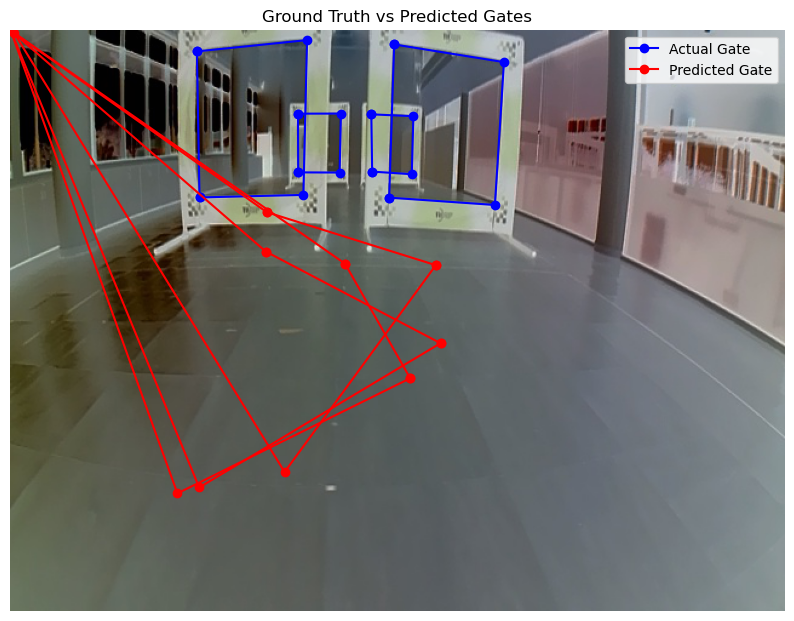

In [16]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np

# Define visibility threshold
visibility_threshold = 1  # Change this value to set the visibility threshold

# Load the first image and target from the dataset
image, target = dataset[1000]  # Adjust the index if you want a different image
image = image.to(device)  # Move image to GPU if necessary

# Get ground truth coordinates and confidence
gt_coords = target["coords"]
gt_conf = target["conf"]

print(f"Ground Truth Coordinates: {gt_coords}")
print(f"Ground Truth Confidence: {gt_conf}")


# Ensure the model is in evaluation mode
model.eval()

# Predict the gates using the model
with torch.no_grad():
    pred_coords, pred_conf = model(image.unsqueeze(0))  # Add batch dimension

# Print the predicted coordinates and confidence
print(f"actual: {pred_coords}")
print(f"pred_conf: {pred_conf}")
# Move tensors to CPU for visualization
image = image.cpu().numpy().transpose(1, 2, 0)  # Convert image to HWC format
pred_coords = pred_coords.squeeze(0).cpu().numpy()
pred_conf = pred_conf.squeeze(0).cpu().numpy()
gt_coords = gt_coords.cpu().numpy()
gt_conf = gt_conf.cpu().numpy()

# Undo normalization if necessary
image = (image * 255).astype(np.uint8)

# Create a figure for the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

# Plot actual gates in blue
for i in range(len(gt_conf)):
    if gt_conf[i] > 0.5:  # Only plot gates with confidence greater than 0.5
        gate = gt_coords[i].reshape(-1, 3)
        xy = gate[:, :2] * image.shape[1::-1]
        visibility = gate[:, 2]

        # Plot points with visibility >= visibility_threshold
        plt.plot(
            xy[visibility >= visibility_threshold, 0],
            xy[visibility >= visibility_threshold, 1],
            "bo-",
            markerfacecolor="blue",
            label="Actual Gate" if i == 0 else "",
        )

        # Close the loop if all points have visibility >= visibility_threshold
        if np.all(visibility >= visibility_threshold):
            plt.plot([xy[-1, 0], xy[0, 0]], [xy[-1, 1], xy[0, 1]], "bo-")

# Plot predicted gates in red
for i in range(len(pred_conf)):
    if pred_conf[i] > 0.5:  # Only plot gates with confidence greater than 0.5
        gate = pred_coords[i].reshape(-1, 3)
        xy = gate[:, :2] * image.shape[1::-1]
        visibility = gate[:, 2]

        # Plot points with visibility >= visibility_threshold
        plt.plot(
            xy[visibility >= visibility_threshold, 0],
            xy[visibility >= visibility_threshold, 1],
            "ro-",
            markerfacecolor="red",
            label="Predicted Gate" if i == 0 else "",
        )

        # Close the loop if all points have visibility >= visibility_threshold
        if np.all(visibility >= visibility_threshold):
            plt.plot([xy[-1, 0], xy[0, 0]], [xy[-1, 1], xy[0, 1]], "ro-")

# Add legend and show the plot
plt.legend()
plt.title("Ground Truth vs Predicted Gates")
plt.show()

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from moviepy.editor import ImageSequenceClip

In [14]:
def create_prediction_video(
    dataset,
    model,
    device,
    visibility_threshold=1,
    output_file="lstm_predictions.mp4",
    fps=10,
):
    frames = []

    # Iterate through the entire dataset
    for idx in range(500):
        # Load the image and target from the dataset
        image, target = dataset[idx]
        image = image.to(device)  # Move image to GPU if necessary
        gt_coords = target["coords"]
        gt_conf = target["conf"]

        # Predict the gates using the model
        model.eval()
        with torch.no_grad():
            pred_coords, pred_conf = model(image.unsqueeze(0))  # Add batch dimension

        # Move tensors to CPU for visualization
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert image to HWC format
        pred_coords = pred_coords.squeeze(0).cpu().numpy()
        pred_conf = pred_conf.squeeze(0).cpu().numpy()
        gt_coords = gt_coords.cpu().numpy()
        gt_conf = gt_conf.cpu().numpy()

        # Undo normalization if necessary
        image = (image * 255).astype(np.uint8)

        # Create a figure for the image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image)
        ax.axis("off")

        # Plot actual gates in blue
        for i in range(len(gt_conf)):
            if gt_conf[i] > 0.5:  # Only plot gates with confidence greater than 0.5
                gate = gt_coords[i].reshape(-1, 3)
                xy = gate[:, :2] * image.shape[1::-1]
                visibility = gate[:, 2]

                # Plot points with visibility >= visibility_threshold
                ax.plot(
                    xy[visibility >= visibility_threshold, 0],
                    xy[visibility >= visibility_threshold, 1],
                    "bo-",
                    markerfacecolor="blue",
                    label="Actual Gate" if i == 0 else "",
                )

                # Close the loop if all points have visibility >= visibility_threshold
                if np.all(visibility >= visibility_threshold):
                    ax.plot([xy[-1, 0], xy[0, 0]], [xy[-1, 1], xy[0, 1]], "bo-")

        # Plot predicted gates in red
        for i in range(len(pred_conf)):
            if pred_conf[i] > 0.5:  # Only plot gates with confidence greater than 0.5
                gate = pred_coords[i].reshape(-1, 3)
                xy = gate[:, :2] * image.shape[1::-1]
                visibility = gate[:, 2]

                # Plot points with visibility >= visibility_threshold
                ax.plot(
                    xy[visibility >= visibility_threshold, 0],
                    xy[visibility >= visibility_threshold, 1],
                    "ro-",
                    markerfacecolor="red",
                    label="Predicted Gate" if i == 0 else "",
                )

                # Close the loop if all points have visibility >= visibility_threshold
                if np.all(visibility >= visibility_threshold):
                    ax.plot([xy[-1, 0], xy[0, 0]], [xy[-1, 1], xy[0, 1]], "ro-")

        # Add legend and title
        ax.legend()
        ax.set_title(f"Ground Truth vs Predicted Gates - Frame {idx}")

        # Save frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

        plt.close(fig)  # Close the figure to free memory

        # Print progress
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{len(dataset)} frames.")

    # Create and save video
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(output_file, codec="libx264")

In [15]:
output_video_path = "lstm_predictions.mp4"
create_prediction_video(
    dataset=dataset,
    model=model,
    device=device,
    visibility_threshold=1,
    output_file=output_video_path,
    fps=10,
)

Processed 50/3213 frames.
Processed 100/3213 frames.
Processed 150/3213 frames.
Processed 200/3213 frames.
Processed 250/3213 frames.
Processed 300/3213 frames.
Processed 350/3213 frames.
Processed 400/3213 frames.
Processed 450/3213 frames.
Processed 500/3213 frames.
Moviepy - Building video lstm_predictions.mp4.
Moviepy - Writing video lstm_predictions.mp4



Moviepy - Done !
Moviepy - video ready lstm_predictions.mp4
